# 1. Reflection from auction settings -> GT models assignment
1. 试图制定一个映射：from auction settings to GT_choice
    - 先把embedding变成1dim，这样features一共是4dim
    - 然后根据PCA，4 dim-> 1dim
    - 1 dim的结果，按照分界点划分，使得尽可能达到1:1的比例
2. Note:
    - 因为d=0会使得GT-1求得的概率为0，所以限制：d=0时，一定由GT-2来生成数据

In [1]:
data_auction_setting_root = r"../data/train_8_all"

# embedding
prod_embedding_small_path = "../data/small_prod_embedding_4.csv"
prod_embedding_large_path = "E:\DATA\large_dta\large_prod_embedding_4.csv"

# output_path
auction_assign_path = "../data/auction_assign.csv"

import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.pyplot as plt
from functools import reduce

# scaling
RANGE = (-1,1)
alpha_range = (-0.3, 0.3)
labda_range = (0, 18)

# columns name
COL_NAME = ['bidincrement','bidfee','retail','item']
COL_NAME_output = ['GT_choice','alpha','labda']

- 先用PCA把4 dim的product embeddings -> 1dim

In [2]:
# 读取embeddings
prod_embedding_small = pd.read_csv(prod_embedding_small_path, encoding="utf-8")
prod_embedding_large = pd.read_csv(prod_embedding_large_path, encoding="utf-8")
prod_embedding = pd.concat([prod_embedding_small,prod_embedding_large],axis=0,ignore_index=True)
prod_embedding.drop(columns=['desc'],inplace=True)

In [3]:
# 4 dim -> 1dim
pca_emd = PCA(n_components=1)
emd_1dim = pca_emd.fit_transform(prod_embedding)

emd_1dim.shape

(1276, 1)

In [4]:
# 合并旧的data和新的embedding数据
all_data_path = os.listdir(data_auction_setting_root)

# 将所有data setting放在一张表中，方便training
data = pd.DataFrame()
for i in range(len(all_data_path)):
    data_path = os.path.join(data_auction_setting_root,all_data_path[i])
    data_i = pd.read_csv(data_path, encoding="utf-8")

    # 合并成一行
    data_i_tmp = pd.concat([data_i.iloc[:,0:3],pd.DataFrame(emd_1dim[i])],axis=1)
    # 再合并成一张大表
    data = pd.concat([data,data_i_tmp],axis=0)

data.shape

(1276, 4)

In [5]:
data.columns=COL_NAME
data.head()

,bidincrement,bidfee,retail,item
0,0.15,0.75,499.99,-0.069145
0,0.15,0.75,169.99,0.036301
0,0.15,0.75,299.99,-0.008107
0,0.15,0.75,89.99,0.074671
0,0.15,0.75,59.99,-0.036966


- scaling into `RANGE`, 使得每个feature的权重一样

In [6]:
def scale_range(data,RANGE):

    scaler = MinMaxScaler(RANGE)
    new_df = pd.DataFrame(index=data.index, columns=data.columns)   # 创造一个shape相同的df
    for i in range(data.shape[1]):
        new_df.iloc[:,i] =  scaler.fit_transform(np.array(data.iloc[:,i]).reshape(-1, 1))
    return new_df


In [7]:
# scaling
data_scaled = scale_range(data,RANGE)
data_scaled.shape

(1276, 4)

In [8]:
data.head()

,bidincrement,bidfee,retail,item
0,0.15,0.75,499.99,-0.069145
0,0.15,0.75,169.99,0.036301
0,0.15,0.75,299.99,-0.008107
0,0.15,0.75,89.99,0.074671
0,0.15,0.75,59.99,-0.036966


In [9]:
data_scaled.head()

,bidincrement,bidfee,retail,item
0,0.25,1.0,-0.647919,-0.360915
0,0.25,1.0,-0.884359,0.023168
0,0.25,1.0,-0.791216,-0.138587
0,0.25,1.0,-0.941678,0.162927
0,0.25,1.0,-0.963173,-0.243705


- 方法一：pca，降至1维并且标准化到[-1,1]上
- 选用分界点为-0.6

In [10]:
# 实例化PCA算法，并将数据降到1维
pca = PCA(n_components=1)
pca_result = pca.fit_transform(data_scaled)

# 同时将PCA的输出限制在RANGE范围内
# pca_result_ranged = RANGE[0] + (pca_result - np.min(pca_result)) * (RANGE[1] - RANGE[0]) / (np.max(pca_result) - np.min(pca_result))
scaler = MinMaxScaler(RANGE)
pca_result_ranged = scaler.fit_transform(pca_result)
pca_result_ranged.shape

(1276, 1)

In [11]:
# type assign
auction_assign = np.array([0]*len(data_scaled))

Choice_point = -0.6
auction_assign[np.where(pca_result_ranged < Choice_point)[0]] = 1
auction_assign[np.where(pca_result_ranged >= Choice_point)[0]] = 0

- 限制d=0时，一定由GT-2来控制数据

In [12]:
# idx_d = np.where(data.bidincrement==0)[0]
# auction_assign[idx_d] == 1

- 检查比例

In [13]:
print("GT-2的比例为：")
len(auction_assign[auction_assign==1]) / len(auction_assign)

GT-2的比例为：


0.512539184952978

In [14]:
auction_assign_df = pd.DataFrame(auction_assign,columns=['GT_choice'])
auction_assign_df.reset_index(drop=True,inplace=True)
auction_assign_df.shape


(1276, 1)

- 可视化

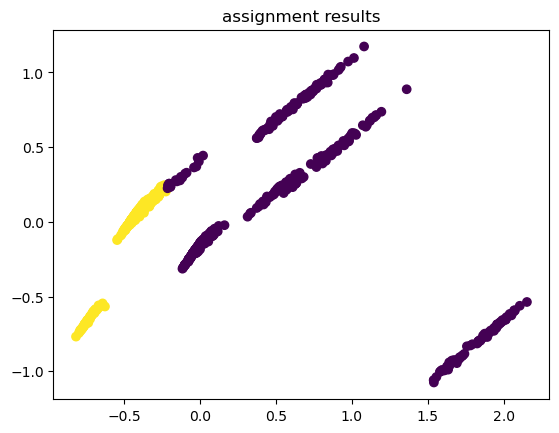

In [15]:
# 将数据降到2维
pca = PCA(n_components=2)
all_data_2dim = pca.fit_transform(data_scaled)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(all_data_2dim[:, 0], all_data_2dim[:, 1], c=auction_assign_df.GT_choice)
plt.title("assignment results")
plt.show()


# 2. Reflection from auction settings -> alpha,lambda.
1. alpha，lambda和4-dim feature（auction config）之间有一个线性的映射
2. 系数：
    - coeff_labda = [0.07, 0.18, 0.38, 0.37]
    - coeff_alpha = [0.31, 0.24, 0.18, 0.27]

In [16]:
def get_coeff():
    shape_coeff = [1, 1, 1, 1]
    x = np.random.dirichlet(shape_coeff)

    # 保留2位小数
    x = np.round(x,2)
    x[-1] = np.round(1-np.sum(x[0:-1]),2)
    return x

- 只运行一次，得到系数

In [524]:
# coeff_alpha = get_coeff().tolist()
# coeff_labda = get_coeff().tolist()
# coeff_alpha,coeff_labda

In [17]:
coeff_alpha = [0.31, 0.24, 0.18, 0.27]
coeff_labda = [0.07, 0.18, 0.38, 0.37]
sum(coeff_alpha),sum(coeff_labda)

(1.0, 1.0)

In [18]:
def get_reflection(data, range, coeff):

    # 1. 将data映射到RANGE范围
    data_scaled = scale_range(data,range)

    # print(data_scaled.head())
    # 2. 根据coeff，线性变换
    data_reflcted = pd.DataFrame(np.sum(data_scaled * coeff,axis=1))
    data_reflcted.reset_index(drop=True,inplace=True)
    # print(data_reflcted.head())

    return data_reflcted


In [19]:
reflection_alpha = get_reflection(data, alpha_range, coeff_alpha)
reflection_labda = get_reflection(data, labda_range, coeff_labda)

In [20]:
reflection_alpha.shape

(1276, 1)

- 合并data和assign等

In [21]:
df_groups = [auction_assign_df, reflection_alpha, reflection_labda]

data_params = reduce(lambda left, right: pd.concat([left, right],ignore_index=True,axis=1), df_groups)
data_params.columns = COL_NAME_output
data_params.shape

(1276, 3)

- 合并另一个csv的‘observation’

In [26]:
old_params_path = r"../data/params_and_K_sampled.csv"
old_params = pd.read_csv(old_params_path,encoding="utf-8")
old_params = old_params.iloc[0:data_params.shape[0],:].copy()
data_params['observations'] = old_params.observations

In [27]:
data_params.head()

,GT_choice,alpha,labda,observations
0,1,0.031028,7.359773,320
1,1,0.049371,7.830142,303
2,1,0.041299,7.610045,540
3,1,0.057597,8.099510,253
4,1,0.023499,6.671912,345


In [28]:
data_params.shape

(1276, 4)

In [29]:
data_params.to_csv(auction_assign_path, encoding="utf-8", header=True,index=False)